# Imports

In [2]:
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle

# Dataset Loader

In [3]:
# get path from config.json
with open('config.json') as f:
    config = json.load(f)

# Define paths to the image and annotation folders
train_img_folder = config['train']['train_img_folder']
train_ann_folder = config['train']['train_ann_folder']
labels_path = config['train']['label_files']

In [4]:
class DatasetLoader:
    def __init__(self, img_folder, ann_folder, target_size=(224, 224)):
        self.img_folder = img_folder
        self.ann_folder = ann_folder
        self.target_size = target_size
        self.images = []
        self.annotations = []
    
    def load_dataset(self):
        # Iterate through each annotation file in the "ann" folder
        for ann_file in os.listdir(self.ann_folder):
            if ann_file.endswith('.json'):
                # Extract image filename from annotation filename
                img_filename = ann_file[:-5]  # Remove the last 5 characters (".json")

                # Load the corresponding image using PIL Image
                img_path = os.path.join(self.img_folder, img_filename)
                img = Image.open(img_path)
                
                # Load the annotation data from the JSON file
                with open(os.path.join(self.ann_folder, ann_file), 'r') as f: # r is for read
                    ann_data = json.load(f)
                
                # Extract bounding box coordinates and class labels
                boxes = []
                labels = []

                # for each object in the annotation file
                # extract the coordinates and classTitle
                for obj in ann_data['objects']:
                    xmin, ymin = obj['points']['exterior'][0] # bottom left corner
                    xmax, ymax = obj['points']['exterior'][1] # top right corner

                    # append the coordinates and classTitle to the boxes and labels lists
                    boxes.append([xmin, ymin, xmax, ymax]) 
                    labels.append(obj['classTitle'])
                
                # For every image, append image and annotations to the lists created in the __init__ method
                self.images.append(img) # in PIL Image format
                self.annotations.append({'boxes': boxes, 'labels': labels}) # in dictionary format

        # Display the number of images loaded
        print(f"Number of images loaded: {len(self.images)}")

    def resize_images(self):
        resized_images = []
        for img in self.images:
            resized_img = img.resize(self.target_size)
            resized_images.append(resized_img)
        self.images = resized_images

    def show_image_with_boxes(self, idx=None):

        if idx is None:
            # Select a random image from the dataset
            # get a random index from the images list
            idx = random.randint(0, len(self.images) - 1) 
        img = self.images[idx]
        annotations = self.annotations[idx]
        
        # Plot the image
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        # Get the current Axes instance on the current figure 
        # gca stands for get current axis
        ax = plt.gca()
        # ax is used to add patches to the image (e.g. bounding boxes, labels, etc.)
        
        # Plot bounding boxes

        # for each box and label in the annotations dictionary
        for box, label in zip(annotations['boxes'], annotations['labels']):
            # unpack the box coordinates
            xmin, ymin, xmax, ymax = box
            width = xmax - xmin
            height = ymax - ymin
            # create a Rectangle patch using matplotlib.patches
            rect = Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='b', facecolor='none')
            # add the rectangle to the Axes instance
            ax.add_patch(rect)
            # add a label to the rectangle
            plt.text(xmin, ymin, label, fontsize=10, color='r', verticalalignment='top', backgroundcolor='blue')
            #plt.text(xmin + 0.5 * width, ymin - 3, label, fontsize=10, color='r', ha='right', backgroundcolor='white')
        
        plt.axis('off')
        plt.show()

In [5]:
# train set loader
train_loader = DatasetLoader(train_img_folder, train_ann_folder)
train_loader.load_dataset()

Number of images loaded: 2246


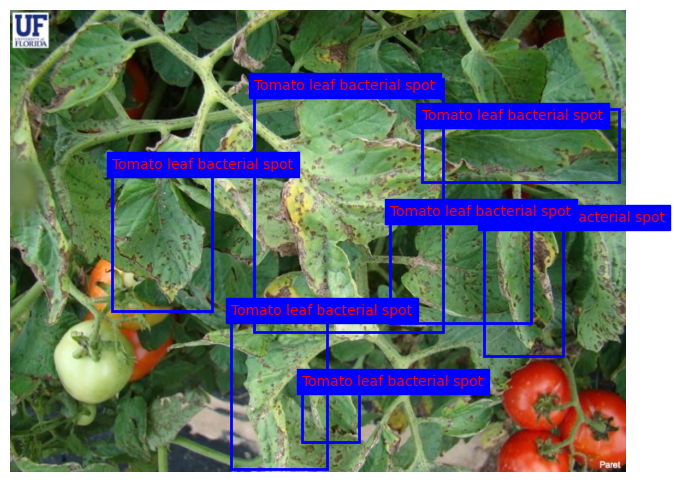

In [6]:
# show random image with bounding boxes
train_loader.show_image_with_boxes()

In [7]:
# print annotations
print(train_loader.annotations[1])

{'boxes': [[761, 115, 1987, 1591], [1478, 565, 2573, 1943]], 'labels': ['Bell_pepper leaf spot', 'Bell_pepper leaf spot']}


# Preprocessing

In [7]:
def extract_class_names(annotations):
    class_names = set()  # Using a set to collect unique class names

    for annotation in annotations:
        labels = annotation['labels']
        class_names.update(labels)  # Add all labels to the set

    class_names = list(class_names)  # Convert set to list
    return class_names

In [8]:
# get class names
class_names = extract_class_names(train_loader.annotations)
print(class_names)
print(len(class_names))

['Blueberry leaf', 'Potato leaf late blight', 'Apple Scab Leaf', 'Tomato leaf mosaic virus', 'Soyabean leaf', 'Potato leaf early blight', 'Apple rust leaf', 'Tomato leaf late blight', 'Squash Powdery mildew leaf', 'Tomato mold leaf', 'Corn leaf blight', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 'Peach leaf', 'Strawberry leaf', 'Tomato two spotted spider mites leaf', 'grape leaf', 'Bell_pepper leaf', 'grape leaf black rot', 'Tomato leaf', 'Tomato leaf yellow virus', 'Bell_pepper leaf spot', 'Apple leaf', 'Corn Gray leaf spot', 'Raspberry leaf', 'Potato leaf', 'Corn rust leaf', 'Cherry leaf']
29


In [9]:
# convert class names to class indices
class_indices = {cls: idx for idx, cls in enumerate(class_names)}
print(class_indices)

{'Blueberry leaf': 0, 'Potato leaf late blight': 1, 'Apple Scab Leaf': 2, 'Tomato leaf mosaic virus': 3, 'Soyabean leaf': 4, 'Potato leaf early blight': 5, 'Apple rust leaf': 6, 'Tomato leaf late blight': 7, 'Squash Powdery mildew leaf': 8, 'Tomato mold leaf': 9, 'Corn leaf blight': 10, 'Tomato Early blight leaf': 11, 'Tomato Septoria leaf spot': 12, 'Tomato leaf bacterial spot': 13, 'Peach leaf': 14, 'Strawberry leaf': 15, 'Tomato two spotted spider mites leaf': 16, 'grape leaf': 17, 'Bell_pepper leaf': 18, 'grape leaf black rot': 19, 'Tomato leaf': 20, 'Tomato leaf yellow virus': 21, 'Bell_pepper leaf spot': 22, 'Apple leaf': 23, 'Corn Gray leaf spot': 24, 'Raspberry leaf': 25, 'Potato leaf': 26, 'Corn rust leaf': 27, 'Cherry leaf': 28}


In [24]:
class Preprocess:
    def __init__(self, images, annotations, ann_folder):
        self.images = images
        self.annotations = annotations
        self.ann_folder = ann_folder

    def resize_images(self, size=(416, 416)):
        resized_images = []
        for image in self.images:
            resized_image = image.resize(size)
            resized_images.append(resized_image)
        print("UPDATE: Images resized to 416x416!")
        return resized_images

    def normalize_images(self, images):
        print("UPDATE: Normalizing images...")
        for img in self.images:
            np_img = np.array(img)
            normalized_np_img = np_img / 255.0
        print("UPDATE: Images normalized!")
        return normalized_np_img
    
    # create labels folder containing .txt files
    # each .txt file contains the class label and bounding box coordinates
    def create_labels(self, labels_folder, target_size=(416, 416), class_indices= class_indices):
        for ann_file, ann in zip(os.listdir(self.ann_folder), self.annotations):
            # Extract image filename from annotation filename
            img_filename = ann_file[:-5]
            filename = img_filename + '.txt'
            with open(os.path.join(labels_folder, filename), 'w') as f:
                for box, label in zip(ann['boxes'], ann['labels']):
                    # unpack the box coordinates
                    xmin, ymin, xmax, ymax = box
                    # normalize the coordinates
                    x = (xmin + xmax) / 2.0 / target_size[0]
                    y = (ymin + ymax) / 2.0 / target_size[1]
                    width = (xmax - xmin) / target_size[0]
                    height = (ymax - ymin) / target_size[1]
                    # get class index from class_indices dictionary
                    label = class_indices[label]
                    # write the label and normalized coordinates to the file
                    f.write(f"{label} {x} {y} {width} {height}\n")
        print("UPDATE: Labels created succesfully!")

In [28]:
pp = Preprocess(train_loader.images, train_loader.annotations, train_ann_folder)

In [10]:
resized_images = pp.resize_images()

UPDATE: Images resized to 416x416!


In [11]:
#normalized_np_img = pp.normalize_images(resized_images)

In [29]:
pp.create_labels(labels_path)

UPDATE: Labels created succesfully!


# get the class names

In [1]:
!cd C:\Users\kruth\leaf_disease_detection\yolov5 && python train.py --img 416 --batch 16 --epochs 200 --data data.yaml --cfg models/yolov5s.yaml --weights '' --name leaf_detect

^C


In [11]:
# do for test
test_img_folder = config['test']['test_img_folder']
test_ann_folder = config['test']['test_ann_folder']
labels_path = config['test']['label_files']

In [12]:
# test set loader
test_loader = DatasetLoader(test_img_folder, test_ann_folder)
test_loader.load_dataset()

Number of images loaded: 231


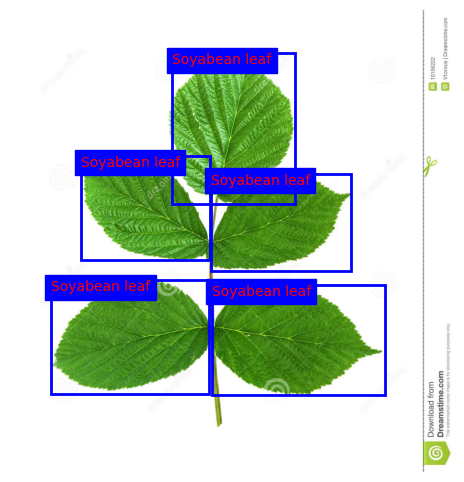

In [13]:
# show random image with bounding boxes
test_loader.show_image_with_boxes()

In [20]:
# get class names
class_names_test = extract_class_names(test_loader.annotations)
print(class_names_test)
print(len(class_names_test))

['Potato leaf late blight', 'Apple Scab Leaf', 'Tomato leaf mosaic virus', 'Soyabean leaf', 'Potato leaf early blight', 'Apple rust leaf', 'Tomato leaf late blight', 'Squash Powdery mildew leaf', 'Tomato mold leaf', 'Corn leaf blight', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 'Peach leaf', 'Strawberry leaf', 'grape leaf', 'Bell_pepper leaf', 'grape leaf black rot', 'Tomato leaf', 'Tomato leaf yellow virus', 'Bell_pepper leaf spot', 'Apple leaf', 'Raspberry leaf', 'Corn Gray leaf spot', 'Blueberry leaf', 'Corn rust leaf', 'Cherry leaf']
27


In [21]:
# convert class names to class indices
class_indices = {cls: idx for idx, cls in enumerate(class_names)}
print(class_indices)

{'Potato leaf late blight': 0, 'Apple Scab Leaf': 1, 'Tomato leaf mosaic virus': 2, 'Soyabean leaf': 3, 'Potato leaf early blight': 4, 'Apple rust leaf': 5, 'Tomato leaf late blight': 6, 'Squash Powdery mildew leaf': 7, 'Tomato mold leaf': 8, 'Corn leaf blight': 9, 'Tomato Early blight leaf': 10, 'Tomato Septoria leaf spot': 11, 'Tomato leaf bacterial spot': 12, 'Peach leaf': 13, 'Strawberry leaf': 14, 'grape leaf': 15, 'Bell_pepper leaf': 16, 'grape leaf black rot': 17, 'Tomato leaf': 18, 'Tomato leaf yellow virus': 19, 'Bell_pepper leaf spot': 20, 'Apple leaf': 21, 'Raspberry leaf': 22, 'Corn Gray leaf spot': 23, 'Blueberry leaf': 24, 'Corn rust leaf': 25, 'Cherry leaf': 26}


In [25]:
# preprocess test set
pp = Preprocess(test_loader.images, test_loader.annotations, test_ann_folder)

In [26]:
pp.create_labels(labels_path)

UPDATE: Labels created succesfully!
